<a href="https://colab.research.google.com/github/dtoralg/INESDI_Data-Science_ML_IA/blob/main/%5B04%5D%20-%20Modelos%20No%20Supervisados/No_supervisados_Ejercicio_4_lof_mall_customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# No supervisados - Ejercicio 4: lof_mall_customers.ipynb

Este notebook es **I do**. Está completamente resuelto. Vas a aprender a usar **Local Outlier Factor (LOF)** para detectar anomalías en un dataset de clientes (`Mall Customers`). Ejecuta las celdas y lee los comentarios para entender cada paso. El notebook incluye carga robusta del dataset, EDA, preprocesado, ajuste de LOF, análisis de sensibilidad de hiperparámetros, comparación con DBSCAN y perfilado de outliers.

## Objetivos

- Cargar y explorar el dataset *Mall Customers*.
- Preparar las variables y estandarizarlas.
- Ajustar Local Outlier Factor, interpretar `negative_outlier_factor_` y elegir `n_neighbors` y `contamination`.
- Visualizar outliers en espacio PCA 2D y comparar con ruido identificado por DBSCAN.
- Perfilar los outliers y proponer acciones prácticas.

In [1]:
# 1) Imports y configuración
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

np.random.seed(42)
print('Librerías cargadas')

Librerías cargadas


### 2) Carga del dataset

In [2]:
url = 'https://raw.githubusercontent.com/dtoralg/INESDI_Data-Science_ML_IA/refs/heads/main/%5B04%5D%20-%20Modelos%20No%20Supervisados/Mall_Customers.csv'
df = pd.read_csv(url)
print('Cargado desde', url)

Cargado desde https://raw.githubusercontent.com/dtoralg/INESDI_Data-Science_ML_IA/refs/heads/main/%5B04%5D%20-%20Modelos%20No%20Supervisados/Mall_Customers.csv


### 3) Exploración rápida

Revisa nulos, tipos y estadísticas; observa las distribuciones para entender posibles anomalías visuales.

In [3]:
print('Porcentaje de nulos por columna:')
print((df.isnull().mean()*100).round(2))
print('\nTipos de columnas:')
print(df.dtypes)

display(df.select_dtypes(include=[np.number]).describe().T)

Porcentaje de nulos por columna:
CustomerID                0.0
Genre                     0.0
Age                       0.0
Annual Income (k$)        0.0
Spending Score (1-100)    0.0
dtype: float64

Tipos de columnas:
CustomerID                 int64
Genre                     object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


### 4) Preparación: encoding y selección de features

Codifico `Gender` y selecciono las columnas numéricas que usaremos para detección de outliers.

In [4]:
df_proc = df.copy()
if 'Gender' in df_proc.columns:
    le = LabelEncoder()
    df_proc['Gender_enc'] = le.fit_transform(df_proc['Gender'].astype(str))

features = [c for c in ['Age','Annual Income (k$)','Spending Score (1-100)','Gender_enc'] if c in df_proc.columns]
print('Features usadas para LOF:', features)
X = df_proc[features].copy()
display(X.head())

Features usadas para LOF: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']


,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


### 5) Escalado

Escalo las features con StandardScaler para que LOF (basado en distancias) funcione correctamente.

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
display(X_scaled_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Age,200.0,-1.021405e-16,1.002509,-1.496335,-0.724844,-0.204535,0.728432,2.235532
Annual Income (k$),200.0,-2.131628e-16,1.002509,-1.738999,-0.727509,0.035879,0.665675,2.917671
Spending Score (1-100),200.0,-1.465494e-16,1.002509,-1.910021,-0.599793,-0.007764,0.885132,1.894492


### 6) PCA 2D para visualización

Proyectamos los datos a 2 dimensiones para visualizarlos. Esto no afecta al ajuste de LOF (que ejecutaremos sobre X_scaled), pero facilita la interpretación gráfica.

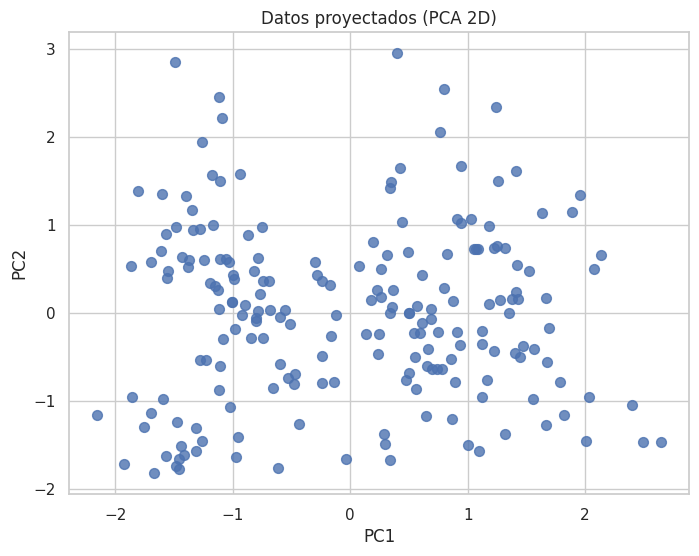

In [6]:
pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], s=50, alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Datos proyectados (PCA 2D)')
plt.grid(True)
plt.show()

### 7) Ajuste de Local Outlier Factor (LOF) — explicación breve

LOF calcula un score local de anomalía basado en densidad: `negative_outlier_factor_` es negativo y cuanto más pequeño, más anómalo. Aquí ajustamos LOF con `fit_predict` (devuelve -1 para outliers) y analizamos resultados.

In [7]:
# Ajuste LOF (parámetros por defecto + contamination)
from sklearn.neighbors import LocalOutlierFactor

# Parámetros iniciales
n_neighbors = 20
contamination = 0.05  # fracción esperada de outliers

lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
lof_labels = lof.fit_predict(X_scaled)  # 1=inlier, -1=outlier

# negative_outlier_factor_ es negativo; invertimos signo para que score positivo = más outlier
lof_scores = -lof.negative_outlier_factor_

# Añadimos resultados al DataFrame
df_proc['lof_label'] = lof_labels
df_proc['lof_score'] = lof_scores

print('Conteo etiquetas LOF:')
print(pd.Series(lof_labels).value_counts())

# Mostrar top outliers por lof_score
top_outliers = df_proc.sort_values('lof_score', ascending=False).head(10)
print('\nTop 10 outliers (LOF score más alto):')
display(top_outliers[[*features, 'lof_score']])

Conteo etiquetas LOF:
 1    190
-1     10
Name: count, dtype: int64

Top 10 outliers (LOF score más alto):


,Age,Annual Income (k$),Spending Score (1-100),lof_score
199,30,137,83,1.963657
2,20,16,6,1.636691
197,32,126,74,1.619739
198,32,137,18,1.558879
195,35,120,79,1.489275
10,67,19,14,1.478653
8,64,19,3,1.430959
0,19,15,39,1.404749
134,20,73,5,1.398702
193,38,113,91,1.393824


### 8) Visualización: outliers en PCA 2D

Dibujo los puntos coloreados por si LOF los marca como outlier y tamaño proporcional al score para enfatizar los casos más anómalos.

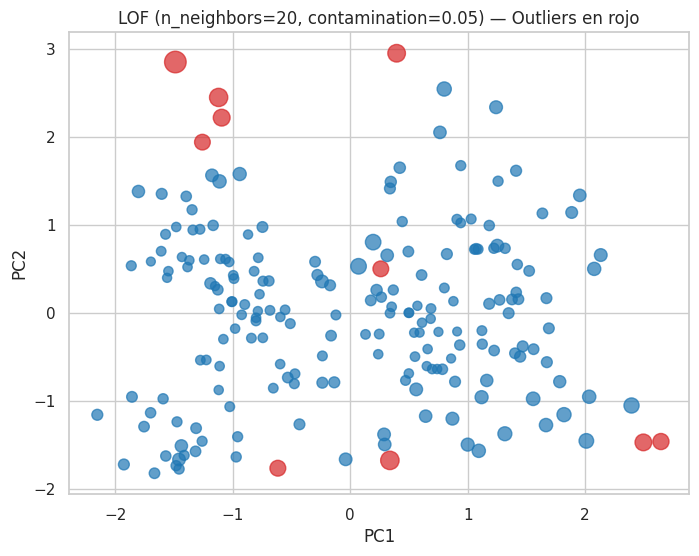

In [8]:
plt.figure(figsize=(8,6))
palette = {1:'tab:blue', -1:'tab:red'}
colors = df_proc['lof_label'].map(palette)
sizes = 40 + (df_proc['lof_score'] - df_proc['lof_score'].min()) * 200  # scale for visualization

plt.scatter(X_pca2[:,0], X_pca2[:,1], c=colors, s=sizes, alpha=0.7)
plt.title(f'LOF (n_neighbors={n_neighbors}, contamination={contamination}) — Outliers en rojo')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

### 9) Sensibilidad a `n_neighbors` y `contamination`

Es importante comprobar cómo varían los resultados cuando se cambia `n_neighbors`. Pruebo varios valores y muestro cuántos outliers detecta cada configuración.

,n_outliers
n_neighbors,
5,10
10,10
20,10
30,10


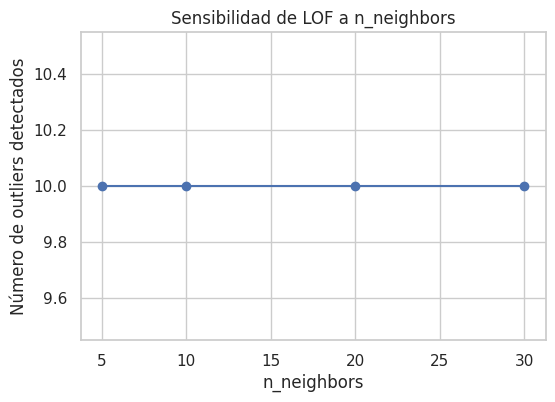

In [9]:
neighbors_list = [5,10,20,30]
contamination = 0.05
sensitivity = []
for nn in neighbors_list:
    lof_tmp = LocalOutlierFactor(n_neighbors=nn, contamination=contamination)
    labels_tmp = lof_tmp.fit_predict(X_scaled)
    n_out = (labels_tmp == -1).sum()
    sensitivity.append({'n_neighbors': nn, 'n_outliers': int(n_out)})

sens_df = pd.DataFrame(sensitivity).set_index('n_neighbors')
display(sens_df)

plt.figure(figsize=(6,4))
plt.plot(sens_df.index, sens_df['n_outliers'], marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('Número de outliers detectados')
plt.title('Sensibilidad de LOF a n_neighbors')
plt.grid(True)
plt.show()

### 10) Comparación con DBSCAN (ruido)

Para ver coincidencias con otro detector, DBSCAN (que marca ruido como -1) y calculo la fracción de overlap entre ruido DBSCAN y outliers LOF.

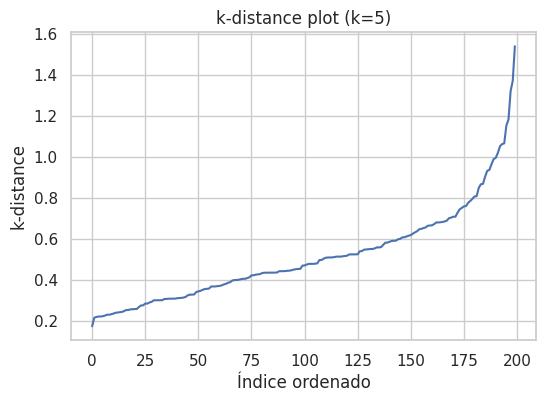

eps estimado (p90): 0.795

Conteo etiquetas DBSCAN (incluye -1 ruido):
 0    194
-1      6
Name: count, dtype: int64

Fracción de outliers LOF que son ruido DBSCAN: 0.3


In [10]:
# Estimación de eps con k-distance (k=5)
neigh = NearestNeighbors(n_neighbors=5)
distances, indices = neigh.fit(X_scaled).kneighbors(X_scaled)
distances = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(distances)
plt.title('k-distance plot (k=5)')
plt.xlabel('Índice ordenado')
plt.ylabel('k-distance')
plt.show()

# Elegimos un eps razonable como percentil 90 de las distancias
eps_est = float(np.percentile(distances, 90))
print('eps estimado (p90):', round(eps_est,3))

# Aplicar DBSCAN
db = DBSCAN(eps=eps_est, min_samples=5)
labels_db = db.fit_predict(X_scaled)
df_proc['db_label'] = labels_db
print('\nConteo etiquetas DBSCAN (incluye -1 ruido):')
print(pd.Series(labels_db).value_counts())

# Overlap entre outliers LOF (-1) y ruido DBSCAN (-1)
lof_out_idx = set(df_proc[df_proc['lof_label']==-1].index)
db_noise_idx = set(df_proc[df_proc['db_label']==-1].index)
if len(lof_out_idx)>0:
    overlap_frac = len(lof_out_idx.intersection(db_noise_idx))/len(lof_out_idx)
else:
    overlap_frac = 0.0
print('\nFracción de outliers LOF que son ruido DBSCAN:', round(overlap_frac,3))

### 11) Perfilado de outliers

Inspecciono las características de los outliers para ver si son errores/entradas ilegítimas o clientes inusuales que merecen atención aparte.

In [11]:
outliers = df_proc[df_proc['lof_label']==-1]
print('Número de outliers detectados:', outliers.shape[0])

# Mostrar estadísticas resumidas de outliers vs inliers
print('\nMedia de variables (inliers vs outliers):')
compare = pd.concat([
    df_proc[df_proc['lof_label']==1][features].mean().rename('inliers'),
    df_proc[df_proc['lof_label']==-1][features].mean().rename('outliers')
], axis=1)
display(compare.round(2))

print('\nAlgunos ejemplos de outliers:')
display(outliers.head(10))

Número de outliers detectados: 10

Media de variables (inliers vs outliers):


,inliers,outliers
Age,39.02,35.7
Annual Income (k$),59.67,77.5
Spending Score (1-100),50.67,41.2



Algunos ejemplos de outliers:


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),lof_label,lof_score,db_label
0,1,Male,19,15,39,-1,1.404749,-1
2,3,Female,20,16,6,-1,1.636691,-1
8,9,Male,64,19,3,-1,1.430959,0
10,11,Male,67,19,14,-1,1.478653,0
134,135,Male,20,73,5,-1,1.398702,0
193,194,Female,38,113,91,-1,1.393824,0
195,196,Female,35,120,79,-1,1.489275,0
197,198,Male,32,126,74,-1,1.619739,0
198,199,Male,32,137,18,-1,1.558879,-1
199,200,Male,30,137,83,-1,1.963657,0


### 12) Qué hacer con los outliers

Discusión práctica: dependiendo de si los outliers son errores de captura, fraudes o clientes con comportamiento especial, las acciones difieren (limpieza, investigación, campañas específicas). Podemos buscar acciones basadas en el perfil detectado.

In [12]:
# Recomendaciones (texto) - modifica según contexto real
recomendaciones = '''
- Investiga manualmente los outliers con valores extremos en 'Annual Income' o 'Spending Score' para descartar errores de captura.
- Si los outliers son clientes de alto gasto extremos, crea una campaña VIP o estudia si son casos repetitivos.
- Si son fraudes o datos incoherentes, exclúyelos del análisis de segmentación o depura la fuente de datos.
'''
print(recomendaciones)


- Investiga manualmente los outliers con valores extremos en 'Annual Income' o 'Spending Score' para descartar errores de captura.
- Si los outliers son clientes de alto gasto extremos, crea una campaña VIP o estudia si son casos repetitivos.
- Si son fraudes o datos incoherentes, exclúyelos del análisis de segmentación o depura la fuente de datos.



### 13) Conclusión

Hemos ejecutado LOF y analizado sensibilidad, visualización en PCA y comparación con DBSCAN. Usa la celda de recomendaciones como plantilla y ajústala al contexto de negocio real.

### Guardar y descargar

Ejecuta todas las celdas y descarga el notebook para conservar el material resuelto.